In [3]:
%matplotlib inline
import numpy as np
from sklearn.datasets import load_iris
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

In [20]:
iris = load_iris()
print(iris.DESCR)
X = iris.data
y = iris.target

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

#### 全結合層

In [5]:
class Linear:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        #self.dW = np.dot(self.x[None,:].T, dout[None,:])
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

#### sigmoid関数

In [6]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

### Relu関数

In [7]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

#### network全体のクラス

In [8]:
class TwoLayerIris:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.random.randn(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.random.randn(output_size)
        
        self.layers = OrderedDict()
        self.layers['Linear1'] = Linear(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Linear2'] = Linear(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        if type(t) != np.ndarray or type(t) != list:
            t = np.eye(3)[t]
        y = self.predict(x)
        return 1/2 * np.sum((y - t) ** 2)
    
    
    def accuracy(self, x, t):
        y = np.argmax(self.predict(x), axis = 1)
        acc = np.sum(y == t)/float(x.shape[0])
        return acc
        
    
    def gradient(self, x, t):
        #backward
        if type(t) != np.ndarray or type(t) != list:
            t = np.eye(3)[t]
        dout = self.predict(x) - t
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Linear1'].dW
        grads['b1'] = self.layers['Linear1'].db
        grads['W2'] = self.layers['Linear2'].dW
        grads['b2'] = self.layers['Linear2'].db
        
        return grads

 12%|█▏        | 1210/10000 [00:00<00:01, 5973.87it/s]

0.3333333333333333
1.0


 32%|███▏      | 3169/10000 [00:00<00:01, 6355.90it/s]

1.0
1.0


 51%|█████     | 5088/10000 [00:00<00:00, 6373.32it/s]

1.0
1.0


 70%|███████   | 7042/10000 [00:01<00:00, 6474.45it/s]

1.0
1.0


 90%|████████▉ | 8974/10000 [00:01<00:00, 6338.92it/s]

1.0
1.0


100%|██████████| 10000/10000 [00:01<00:00, 6305.29it/s]


0.9444444444444444
[[30  0  0]
 [ 0 26  4]
 [ 0  1 29]]


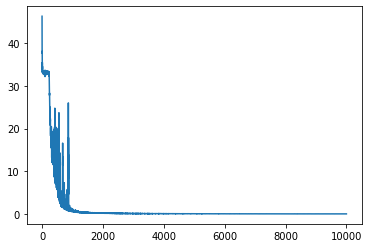

In [19]:
network = TwoLayerIris(input_size=4, hidden_size=4, output_size=3)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.6, stratify=iris.target)
iters_num = 10000
learning_rate = 0.02
batch_size = 100
train_size = X_train.shape[0]
train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for x in tqdm(range(iters_num)):
    batch_mask = np.random.choice(train_size, batch_size)#変更点
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    grad = network.gradient(X_batch, y_batch)
    for key in ['W1', 'b1', 'W2', 'b2']:
            network.params[key] -= learning_rate * grad[key]
    train_loss_list.append(network.loss(X_batch, y_batch))
    if x % 1000 == 0:
        train_acc = network.accuracy(X_train, y_train)
        train_acc_list.append(train_acc)
        print(train_acc)
plt.plot(train_loss_list)
test_acc = network.accuracy(X_test, y_test)
print(test_acc)
y_pred = np.argmax(network.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

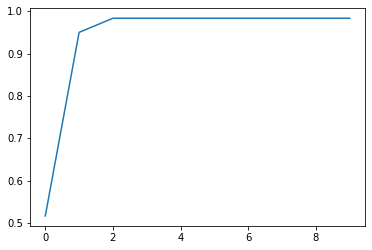

In [18]:
plt.plot(train_acc_list)